<a href="https://colab.research.google.com/github/rvraghvender/DeepLearningProjects/blob/main/ConvolutionNeuralNetworks/NerualArtGeneration/Art_Generation_with_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning & Art: Neural Style Transfer

## 1. Packages


In [6]:
# Importing relevant packages
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
import matplotlib.pyplot as imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
from io import BytesIO
import requests
%matplotlib inline

## 2. Problem Statement

Nerual Style Transfer (NST) is one of the most fun and interesting optimzation techniques in deep learing. It merges two images, namely a **"content" image (C)** and **"style" image (S)**, to create a **"generated" image (G) **. The generated image G combines the "content" of the image C with the "style" of image S.

In this assignment, we are going to cobine the Louvre museum in Paris (content image, C) with the impressionist style of Claude Monet (content image S) to generate the following image:

<img src="https://github.com/rvraghvender/DeepLearningProjects/blob/main/ConvolutionNeuralNetworks/NerualArtGeneration/images/louvre_generated.png?raw=true" style="width:750px;height:200px;">

Let's get started!


## 3. Transfer Learning
Neural Style  Transfer (NST) uses a previously tranied convolution network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning.

We will be using the epynomously named VGG network from the [original NST paper](https://arxiv.org/abs/1508.06576) published by the Visual Geometry Group at University of Oxford in 2014. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been tranied on the very large ImageNet database, and has learned to recoginze a variety of low level features (at the shallow layers) and high level features (at the deeper layer).

Run the below code to load parameters from the VGG model.

In [4]:
tf.random.set_seed(272) # To be consistent with different tries
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.vgg19.VGG19(include_top=False,
                                        input_shape=(img_size, img_size, 3),
                                        weights='imagenet')
vgg.trainable = False
pp.pprint(vgg)

## 4. Neural Style Transfer (NST)

Next, we will be building the Neural Style Transfer (NST) algorithm in three steps:
- First, we will build the content cost function $J_{content} (C, G)$
- Second, we will build the style cost function $J_{style} (S, G)$
- Finally, we will put it all together to get $J(G) = \alpha J_{content}(C, G) + \beta J_{style}(S, G)$. Exciting!

### 4.1 Computing the Content cost

#### 4.1.1 Make Generated Image G Match the Content of Image C

One goal we should aim for when performing NST is for the content in generated image G to match the content of image C. To do so, we'll need an understanding of **shallow versus deep layer**:

- The shallow layers of a ConvNet tend to detect lower-level features such as edges and simple textures.
- The deeper layers tend to detect higher-level features such as more complex textures and object classes.

<h3>To choose a "middle" activation layer $a^{[l]}$:</h3>
We need the "generated" image G to have similar content as the input image C. Suppose we have chosen some layer's activations to represent the content of an image. In practice, we'll get the most visually pleasing results if we choose a layer in the **middle** of the network neither too shallow nor to deep. This ensures that the network detecs both higher-level and lower-level features

<h3> To forward propagate image "C":</h3>

- Set the image C as the input to the pretrained VGG network, and forward propagation.

- Let $a^{(C)}$ be the hidden layer activation in the layer we had chosen. (symbolised as $a^{[l](C)}$, but here the superscript $[l]$ is dropped to simplify the notation). This will be an $n_H \times n_W \times n_C$ tensor.

<h3> To forward propagate image "G":</h3>

- Repeat this process with the image G: Set G as the input, and run forward propagation.
- Let $a^{(G)}$ be the corresponding hidden layer activation.

In this running example, the conent image C wil be the picture of the Louvre Museum in Paris.

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.


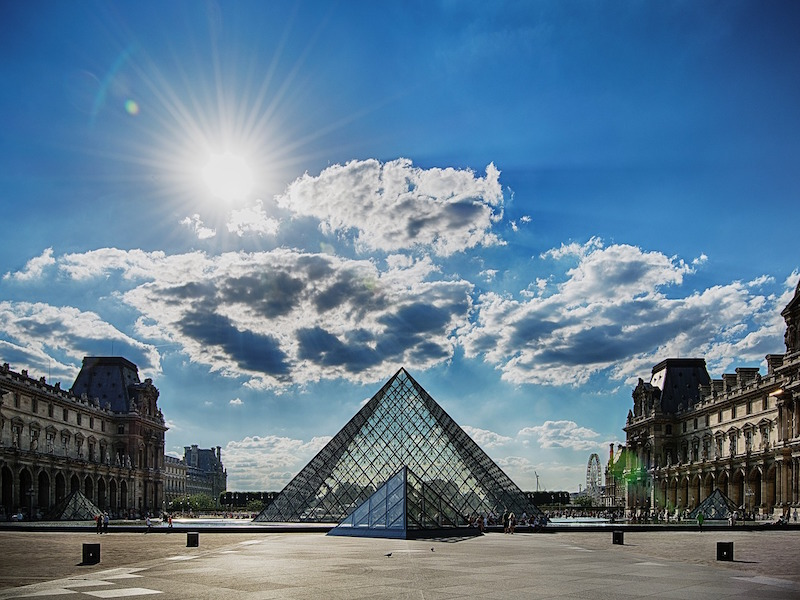

In [9]:
path_to_image = "https://github.com/rvraghvender/DeepLearningProjects/blob/main/ConvolutionNeuralNetworks/NerualArtGeneration/images/louvre.jpg?raw=true"
r = requests.get(path_to_image)
with BytesIO(r.content) as f:
    content_image = Image.open(f).convert(mode='RGB')
print("The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.")
content_image

### 4.1.2 Content Cost Function $J_{content}(C, G)$
One goal we should aim for when performing NST is for the content of image C. A method this is to calculate the content cost function, which will be defined as:

$$J_{content} (C, G) = \dfrac{1}{4 \times n_H \times n_W \times n_C} \sum_{\text{all entries}} (a^{(c)} - a^{(G)})^2$$
- Here, $n_H$, $n_W$ and $n_C$ are the height, width and number of channels of the hidden layer we have chosen, and appear in a normalization term in the cost.
- For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activation.
- In order to compute the cost $J_{content} (C, G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix.
- Technically, this unrolling step isn't needed to compute $J_{content}$, but it will be good practice for when you do need to carry out a similar operation later for computing the style cost $J_{style}$.

<img src="https://github.com/rvraghvender/DeepLearningProjects/blob/main/ConvolutionNeuralNetworks/NerualArtGeneration/images/NST_LOSS.png?raw=true" style="width:800px;height:400px;">